In [ ]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

In [6]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response, select_by_outcome, clasificator_analisis
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import itertools
from sklearn.preprocessing import StandardScaler

rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
# get data
alldat = load_raw_data('../dat')

In [3]:
regions_of_interest = [["VISa"], ["VISam"], ["VISl"], ["VISp"], ["VISpm"], ["VISrl"], ["VISa","VISam","VISl","VISp","VISpm","VISrl"]]
regions_labels =["VISa","VISam","VISl","VISp","VISpm","VISrl", "vis_cortex"]

In [4]:
def get_samples_spikeversion(alldat, selected_regions = ["VISp"], y_window = np.arange(250), contrast_list=None, balance=False):

  if not contrast_list:
    contrast_list = [x for x in itertools.permutations([0,0.25,0.5,1], 2)]
  elif contrast_list == 'right_stimulus':
    contrast_list = [x for x in itertools.permutations([0,0.25,0.5,1], 2) if x[0] < x[1]]
  elif contrast_list == 'left_stimulus':
    contrast_list = [x for x in itertools.permutations([0,0.25,0.5,1], 2) if x[0] > x[1]]

  samples = np.empty((0,len(y_window)))
  y = np.empty((0,))

  for dat in alldat:
    dt = dat['bin_size']
    neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)


    if len(neurons_indices_in_area) > 0:
        # init
        samples_to_left = np.empty((len(neurons_indices_in_area),0,len(y_window)))
        samples_to_right = np.empty((len(neurons_indices_in_area),0,len(y_window)))
        
        # prepare scaler
        z_scaler = StandardScaler()
        z_scaler.fit(dat['spks'][neurons_indices_in_area].reshape((len(neurons_indices_in_area),-1)).T)

        # get samples per contrast
        for contrast in contrast_list:
            trials_correct = select_by_outcome(dat, feedback_type='correct')
            trials_to_left = select_trials(dat, contrast_pair=contrast, response_type = 'to_left') # trials move to left
            trials_to_left = list(set.intersection(set(trials_to_left), set(trials_correct)))
            trials_to_right = select_trials(dat, contrast_pair=contrast, response_type = 'to_right') # trials move to right
            trials_to_right = list(set.intersection(set(trials_to_right), set(trials_correct)))
            spikes_to_left = dat['spks'][neurons_indices_in_area][:,trials_to_left][...,y_window]
            spikes_to_right = dat['spks'][neurons_indices_in_area][:,trials_to_right][...,y_window]
            samples_to_left = np.concatenate((samples_to_left,spikes_to_left),axis=1)
            samples_to_right = np.concatenate((samples_to_right,spikes_to_right),axis=1)

        z_samples_to_left = z_scaler.transform(samples_to_left.reshape((len(neurons_indices_in_area),-1)).T, copy=True)
        z_samples_to_left = z_samples_to_left.T.reshape((len(neurons_indices_in_area),-1,len(y_window))) # Neurons x Trials x Time
        z_samples_to_left = z_samples_to_left.mean(axis=0) # Trials x Time
        
        z_samples_to_right = z_scaler.transform(samples_to_right.reshape((len(neurons_indices_in_area),-1)).T, copy=True)
        z_samples_to_right = z_samples_to_right.T.reshape((len(neurons_indices_in_area),-1,len(y_window))) # Neurons x Trials x Time
        z_samples_to_right = z_samples_to_right.mean(axis=0) # Trials x Time

        if balance:
            n_min = min(z_samples_to_left.shape[0],z_samples_to_right.shape[0])
            samples = np.concatenate((samples,z_samples_to_left[:n_min,...]),axis=0)
            samples = np.concatenate((samples,z_samples_to_right[:n_min,...]),axis=0)
            y = np.concatenate( (y, np.ones(n_min)) )
            y = np.concatenate( (y, np.zeros(n_min)) )
        else:
            samples = np.concatenate((samples,z_samples_to_left),axis=0)
            samples = np.concatenate((samples,z_samples_to_right),axis=0)
            y = np.concatenate( (y, np.ones(z_samples_to_left.shape[0])) )
            y = np.concatenate( (y, np.zeros(z_samples_to_right.shape[0])) )

  return samples, y

def plot_regions_results(regions_of_interest,model_test_score):
    nmodels = len(model_test_score)
    cmap = get_cmap('Spectral')
    colors = cmap(np.arange(nmodels)/nmodels)
    plt.barh(range(nmodels), model_test_score, color=colors, edgecolor='k', linewidth=0.2)
    plt.yticks(range(nmodels),regions_of_interest)
    plt.axvline(x=0.5,lw=2,linestyle='--',color='r')
    plt.xlim([0,1])
    plt.show()

def subplot_scores(regions_of_interest,model_test_score,regions_labels,colors,ax=None):
  if ax is None:
    ax=plt.gca()
  nmodels = len(model_test_score)
  ax.barh(range(nmodels), model_test_score, color=colors, edgecolor='k', linewidth=0.2)
  ax.set_yticks(range(nmodels))
  ax.set_yticklabels(regions_labels)
  ax.axvline(x=0.5,lw=2,linestyle='--',color='r')
  ax.set_xlim([0,1])
  ax.set_xlabel('model accuracy')
  ax.set_ylabel('model region')
  ax.set_title('model scores')

def subplot_coefs(regions_of_interest,model_list,regions_labels,y_window,colors,plot_models,rescale,ax=None):
  if ax is None:
    ax=plt.gca()
  nmodels = len(model_list)
  
  all_coefs = []
  for im in range(nmodels):
    all_coefs.append(model_list[im].coef_[0,:])
  all_coefs = np.vstack(all_coefs)
  if rescale:
    all_coefs = all_coefs/np.abs(all_coefs).max()
  
  ax.axhline(y=0,color="k",lw=1)
  for im in plot_models:
    ax.plot(y_window,all_coefs[im,:],color=colors[im], label=regions_labels[im])
  ax.set_xlabel('time (ms)')
  ax.set_ylabel('model coef')
  if rescale:
    ax.set_ylabel('model coef\n(rel. to max amplitude)')
  ax.set_title(f'model coefficients (best {len(plot_models)})')

def plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window=None,regions_labels=None,cmap_name='Spectral',best_n=None,rescale=False,axes=None):
  if regions_labels is None:
    regions_labels = regions_of_interest
  if axes is None:
    fig, axes = plt.subplots(2, 1)
  if y_window is None:
    y_window = np.arange(model_list[0].coef_.shape[1])
  nmodels = len(model_test_score)

  if best_n is None:
    plot_models = np.arange(nmodels)
  else:
    plot_models = np.argsort(model_test_score)[::-1][:best_n]

  cmap = get_cmap(cmap_name)
  colors = cmap(np.arange(nmodels)/nmodels)
  subplot_scores(regions_of_interest,model_test_score,regions_labels,colors,ax=axes[0])
  subplot_coefs(regions_of_interest,model_list,regions_labels,y_window,colors,plot_models,rescale,ax=axes[1])
  plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# with l1

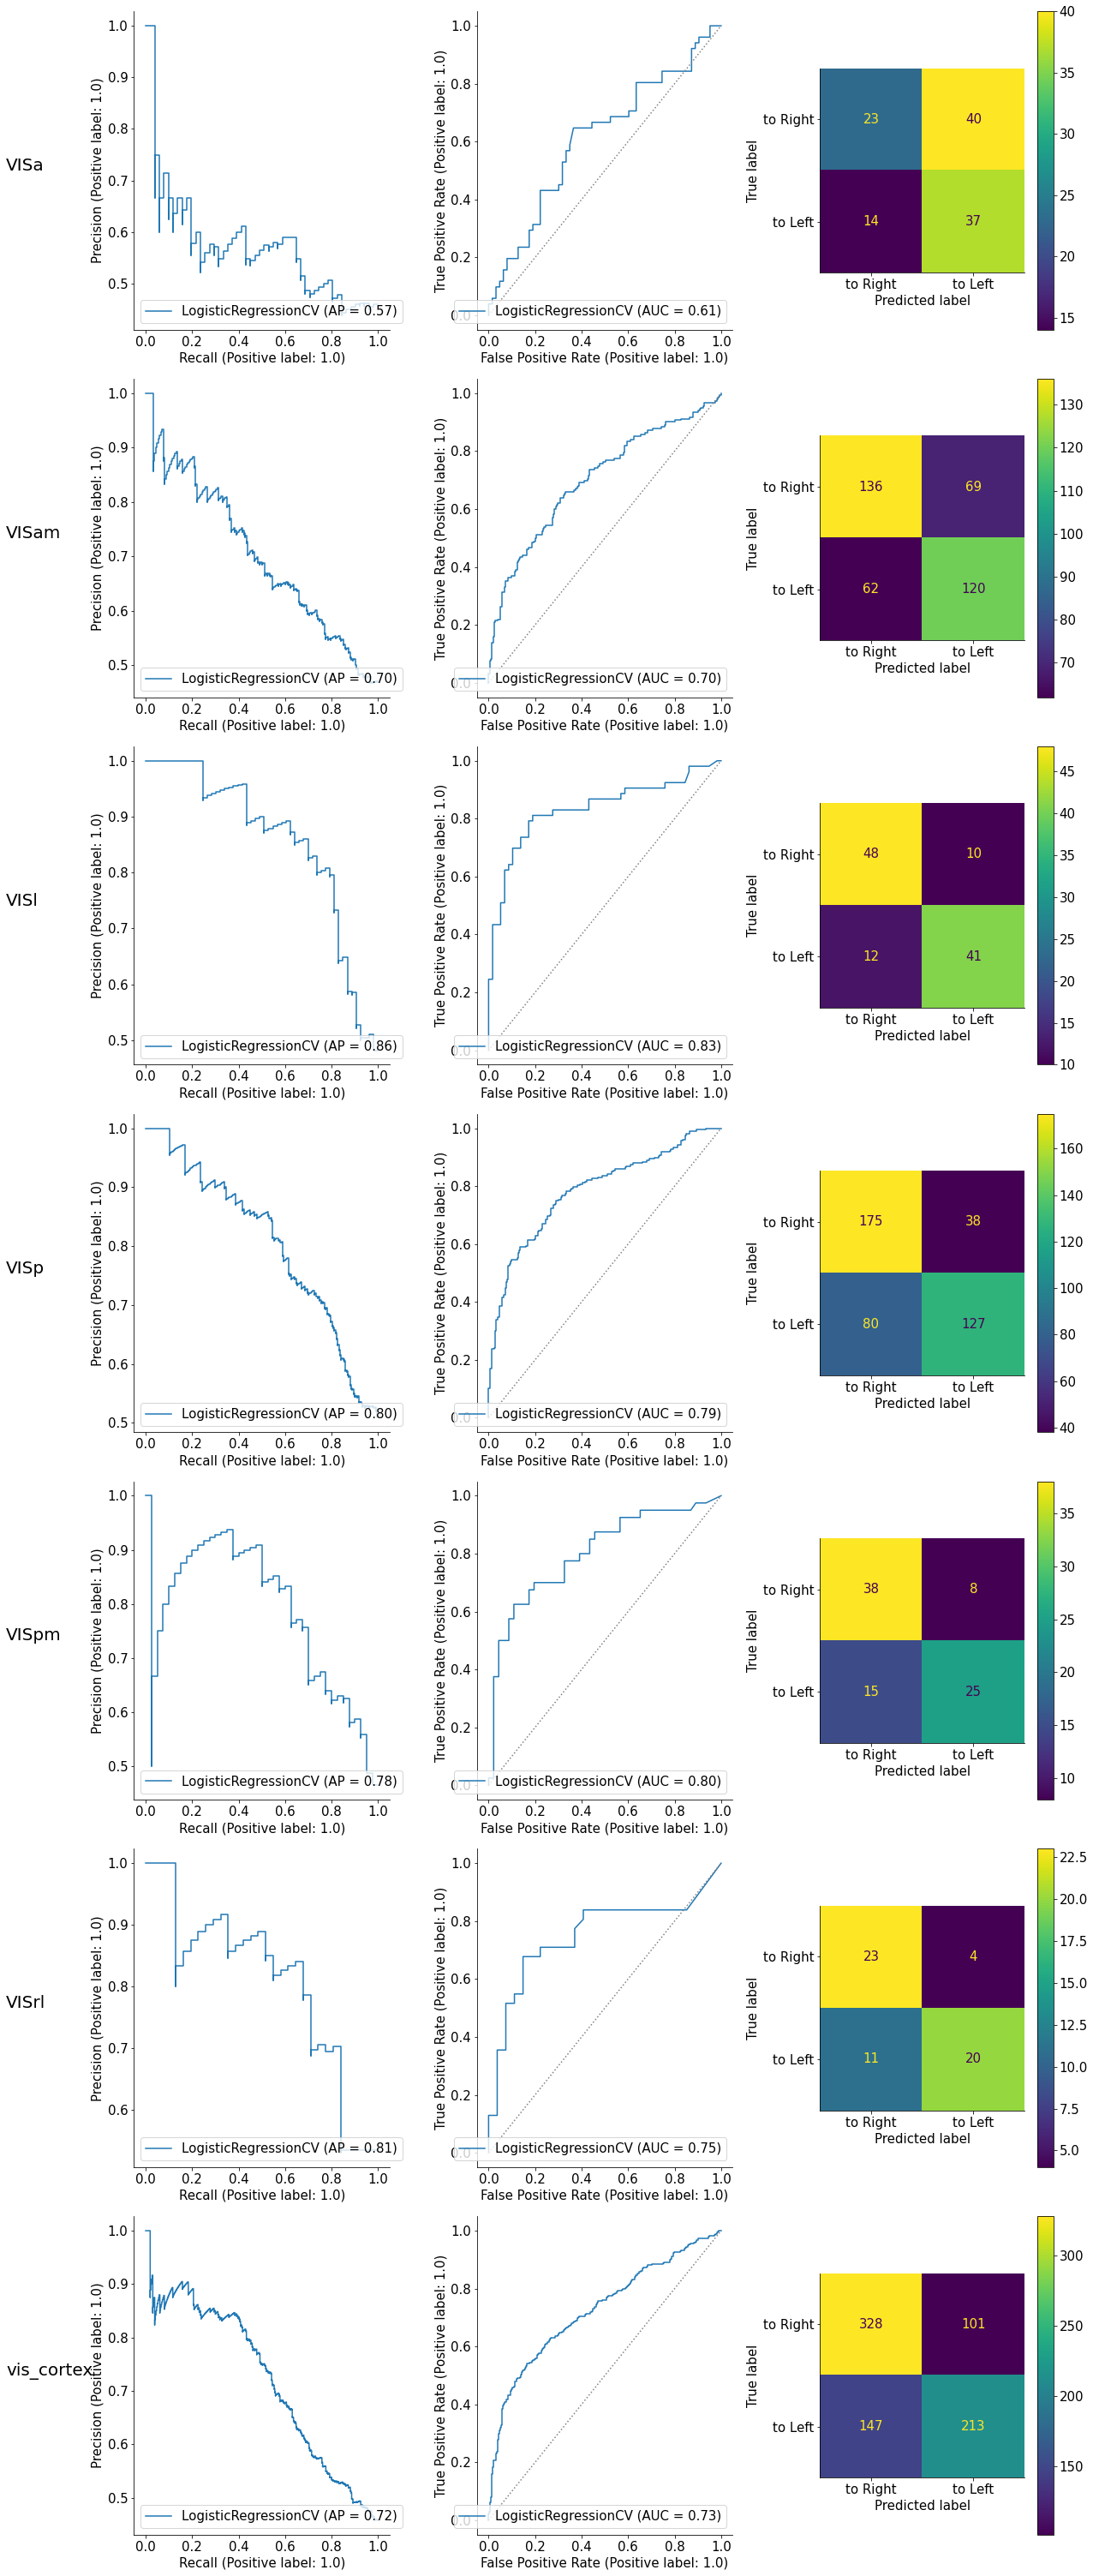

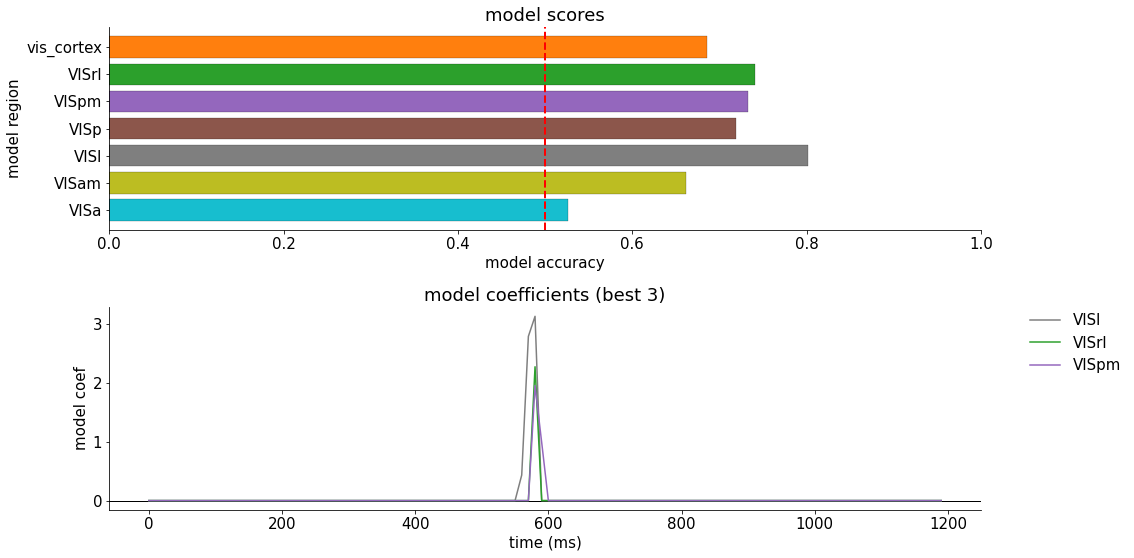

In [7]:
y_window=np.arange(0,120)

nrows, ncols = (len(regions_of_interest),3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

model_list = []
model_test_score = []
for ii, region in enumerate(regions_of_interest):
    region_label = regions_labels[ii]
    samples, y = get_samples_spikeversion(alldat, region, y_window=y_window, contrast_list=None, balance=True)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.3, random_state=42)
    # clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    clf = LogisticRegressionCV(penalty='l1', Cs=10, cv=5, solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
    accu, cm, precision, recall = clasificator_analisis(clf, samples_test, y_test, axes=axes[ii,:])
    axes[ii,0].text(-0.5,0.5,region_label,transform=axes[ii,0].transAxes,fontsize=20)
plt.show()

nrows, ncols = (2,1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16*ncols, 4*nrows))
axes = axes.flatten()
plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window*10,regions_labels,'tab10_r',3,False,axes)
plt.subplots_adjust(hspace=0.4)
plt.show()


## with l1 and no balance

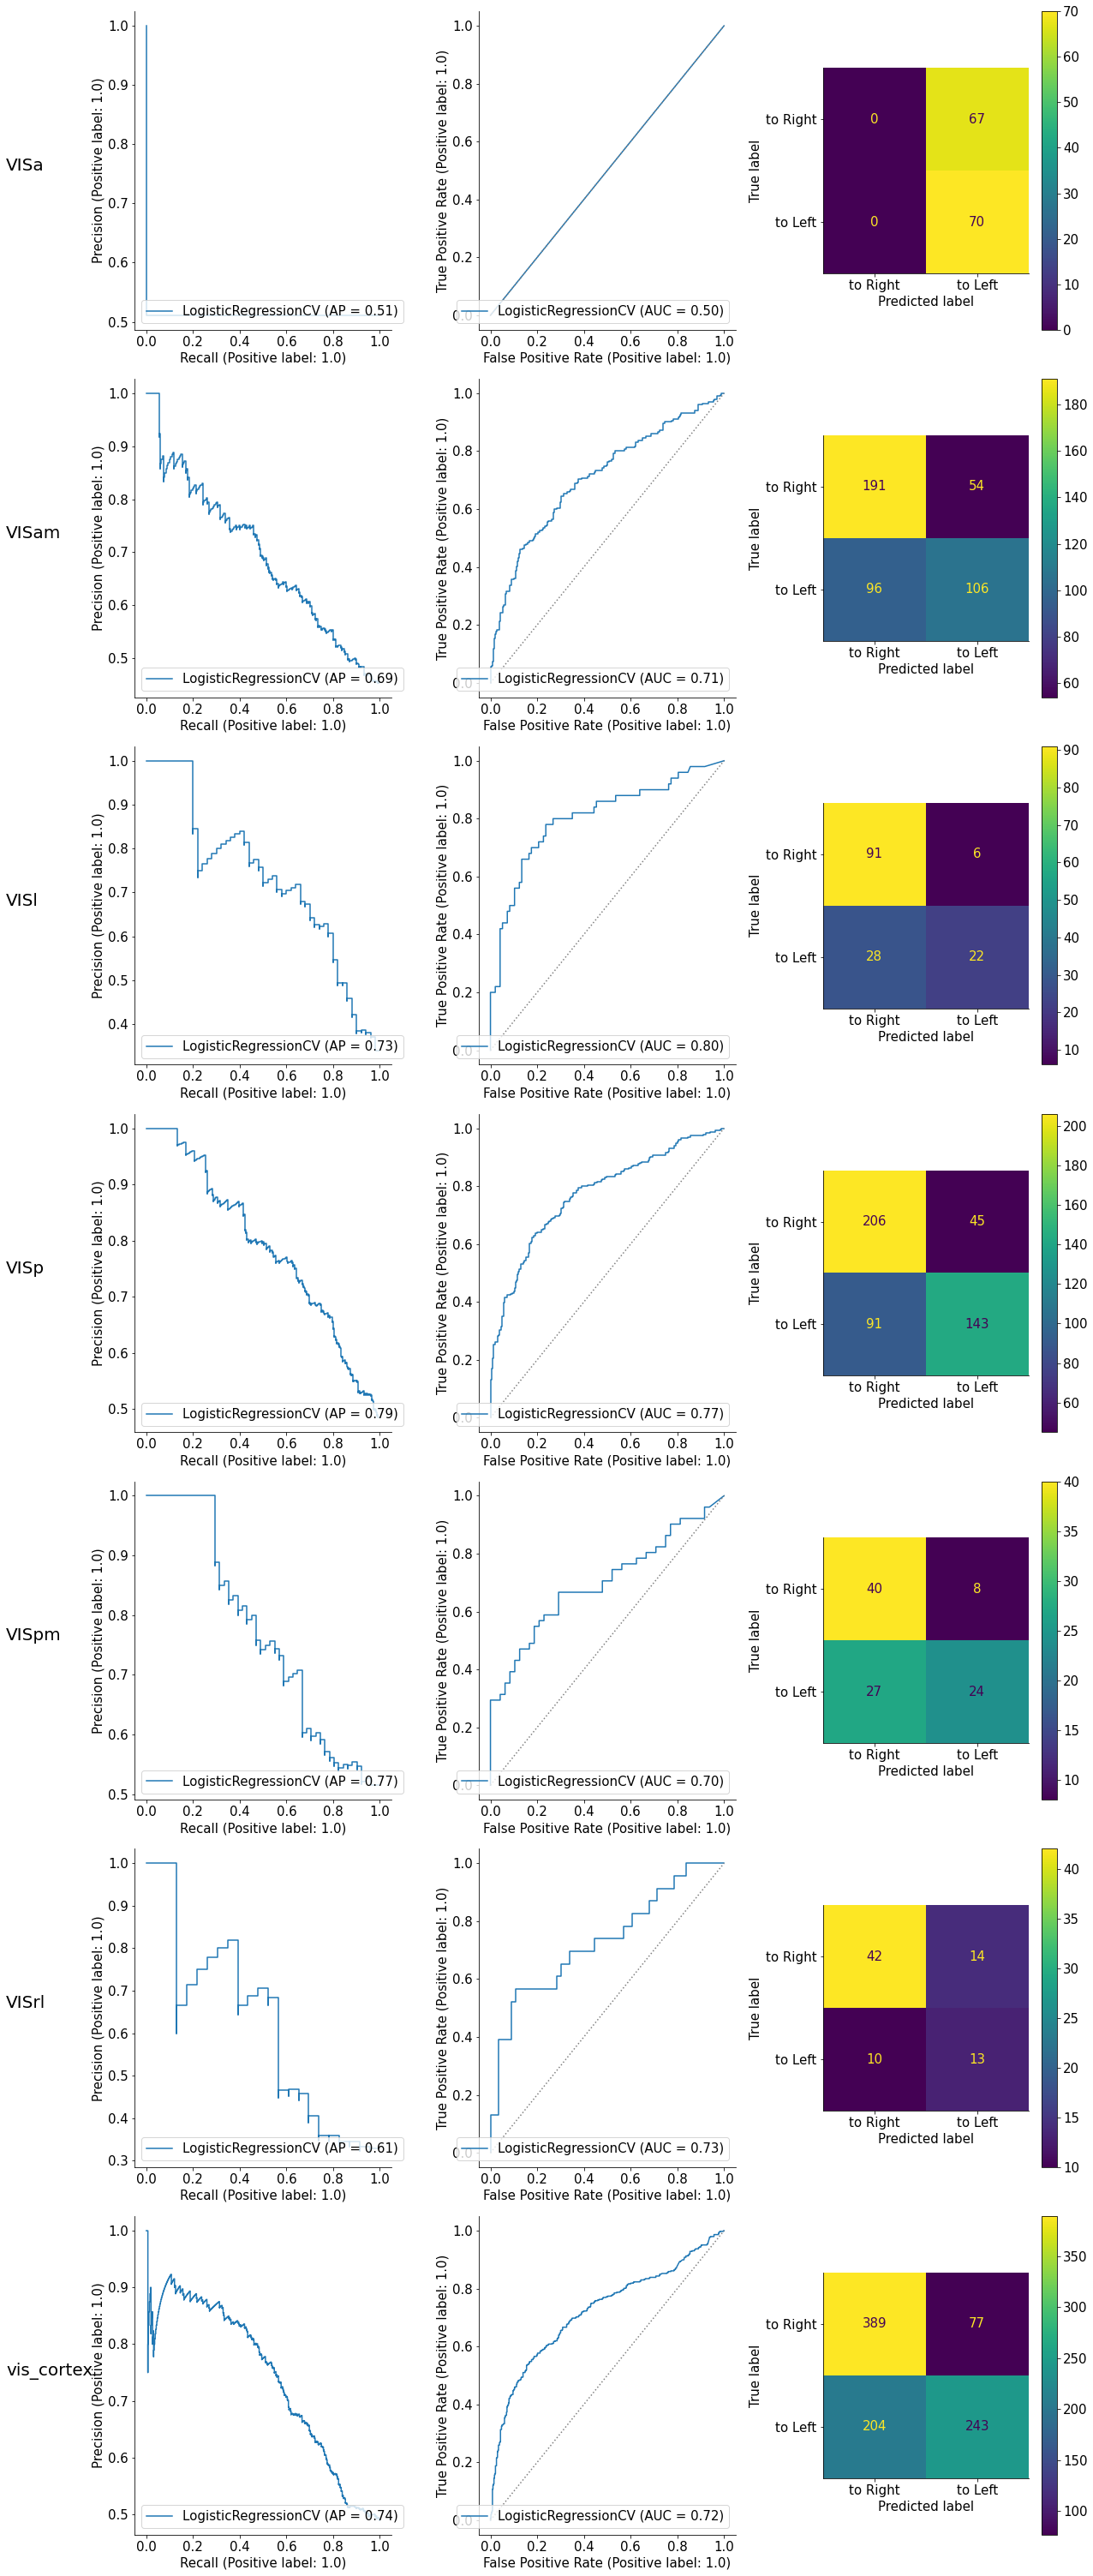

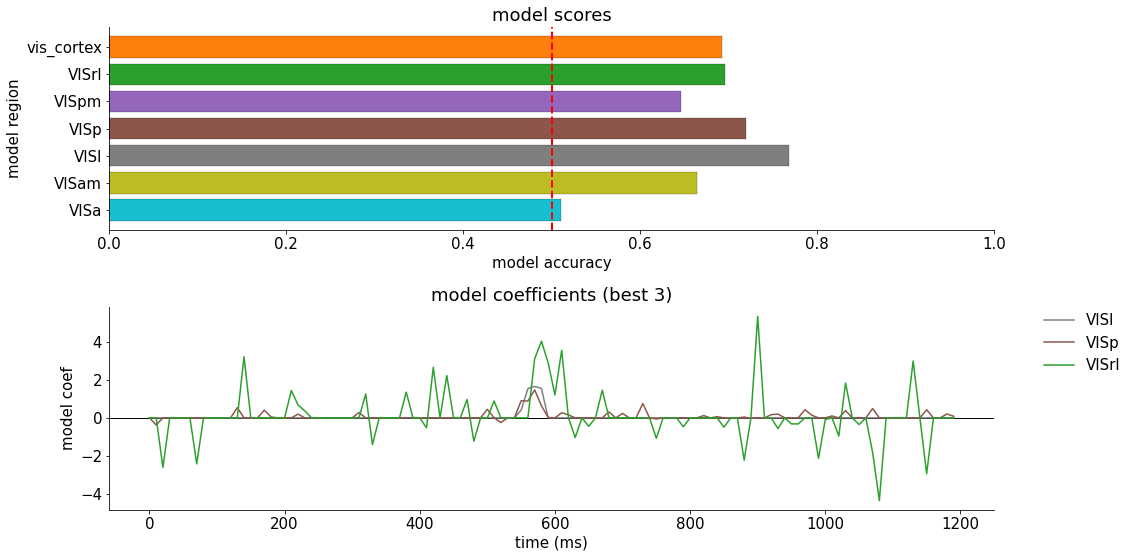

In [8]:
y_window=np.arange(0,120)

nrows, ncols = (len(regions_of_interest),3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

model_list = []
model_test_score = []
for ii, region in enumerate(regions_of_interest):
    region_label = regions_labels[ii]
    samples, y = get_samples_spikeversion(alldat, region, y_window=y_window, contrast_list=None, balance=False)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.3, random_state=42)
    clf = LogisticRegressionCV(penalty='l1', Cs=10, cv=5, solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
    accu, cm, precision, recall = clasificator_analisis(clf, samples_test, y_test, axes=axes[ii,:])
    axes[ii,0].text(-0.5,0.5,region_label,transform=axes[ii,0].transAxes,fontsize=20)
plt.show()

nrows, ncols = (2,1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16*ncols, 4*nrows))
axes = axes.flatten()
plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window*10,regions_labels,'tab10_r',3,False,axes)
plt.subplots_adjust(hspace=0.4)
plt.show()


## with l2

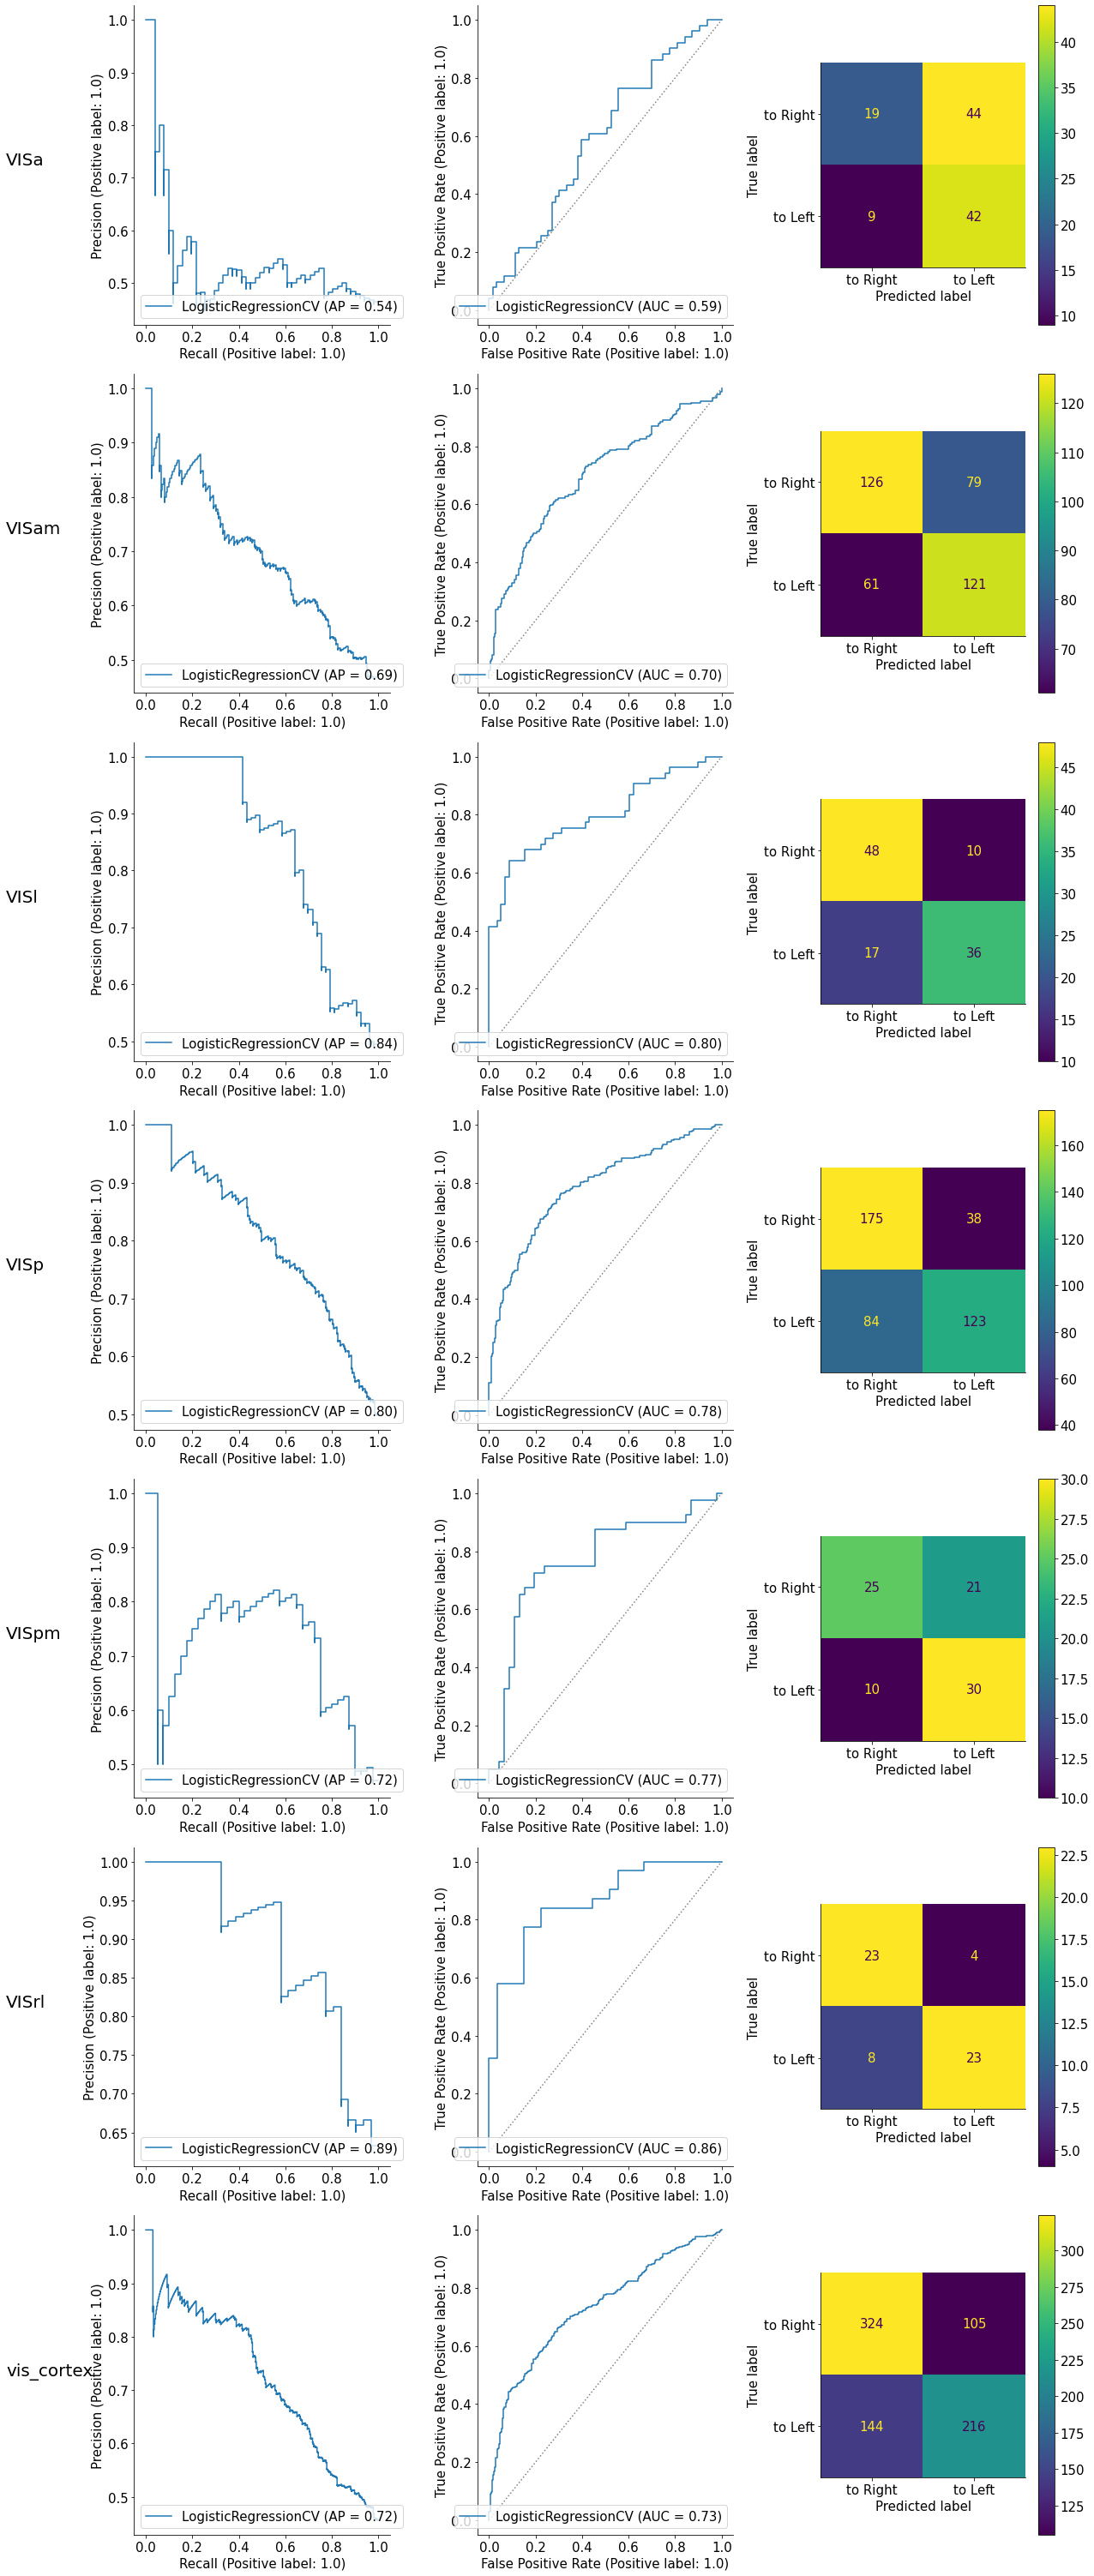

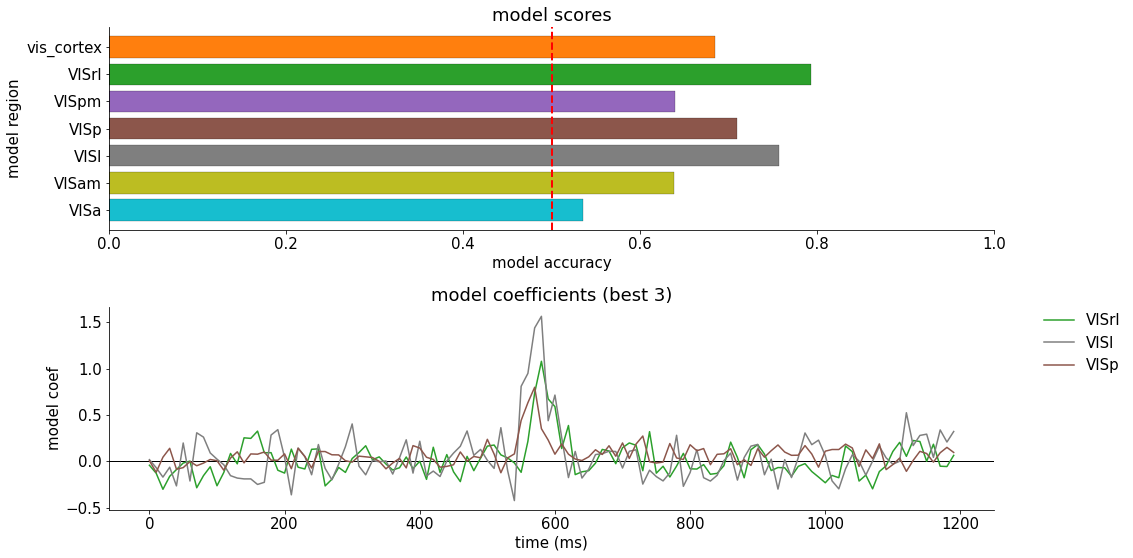

In [9]:
y_window=np.arange(0,120)

nrows, ncols = (len(regions_of_interest),3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

model_list = []
model_test_score = []
for ii, region in enumerate(regions_of_interest):
    region_label = regions_labels[ii]
    samples, y = get_samples_spikeversion(alldat, region, y_window=y_window, contrast_list=None, balance=True)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.3, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
    accu, cm, precision, recall = clasificator_analisis(clf, samples_test, y_test, axes=axes[ii,:])
    axes[ii,0].text(-0.5,0.5,region_label,transform=axes[ii,0].transAxes,fontsize=20)
plt.show()

nrows, ncols = (2,1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16*ncols, 4*nrows))
axes = axes.flatten()
plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window*10,regions_labels,'tab10_r',3,False,axes)
plt.subplots_adjust(hspace=0.4)
plt.show()
